In [ ]:
!unzip Train.zip -d /content/

In [ ]:
!unzip Test.zip -d /content/

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: /content/Test/07631.png  
  inflating: /content/Test/07632.png  
  inflating: /content/Test/07633.png  
  inflating: /content/Test/07634.png  
  inflating: /content/Test/07635.png  
  inflating: /content/Test/07636.png  
  inflating: /content/Test/07637.png  
  inflating: /content/Test/07638.png  
  inflating: /content/Test/07639.png  
  inflating: /content/Test/07640.png  
  inflating: /content/Test/07641.png  
  inflating: /content/Test/07642.png  
  inflating: /content/Test/07643.png  
  inflating: /content/Test/07644.png  
  inflating: /content/Test/07645.png  
  inflating: /content/Test/07646.png  
  inflating: /content/Test/07647.png  
  inflating: /content/Test/07648.png  
  inflating: /content/Test/07649.png  
  inflating: /content/Test/07650.png  
  inflating: /content/Test/07651.png  
  inflating: /content/Test/07652.png  
  inflating: /content/Test/07653.png  
  inflating: /content/Test/07654.png  
  inflati

In [ ]:
# Install YOLOv8 (Ultralytics) and dependencies
!pip install ultralytics
!pip install opencv-python matplotlib pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
# Import libraries

import os
import cv2
import pandas as pd
import numpy as np
import shutil
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from ultralytics import YOLO
import zipfile
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns

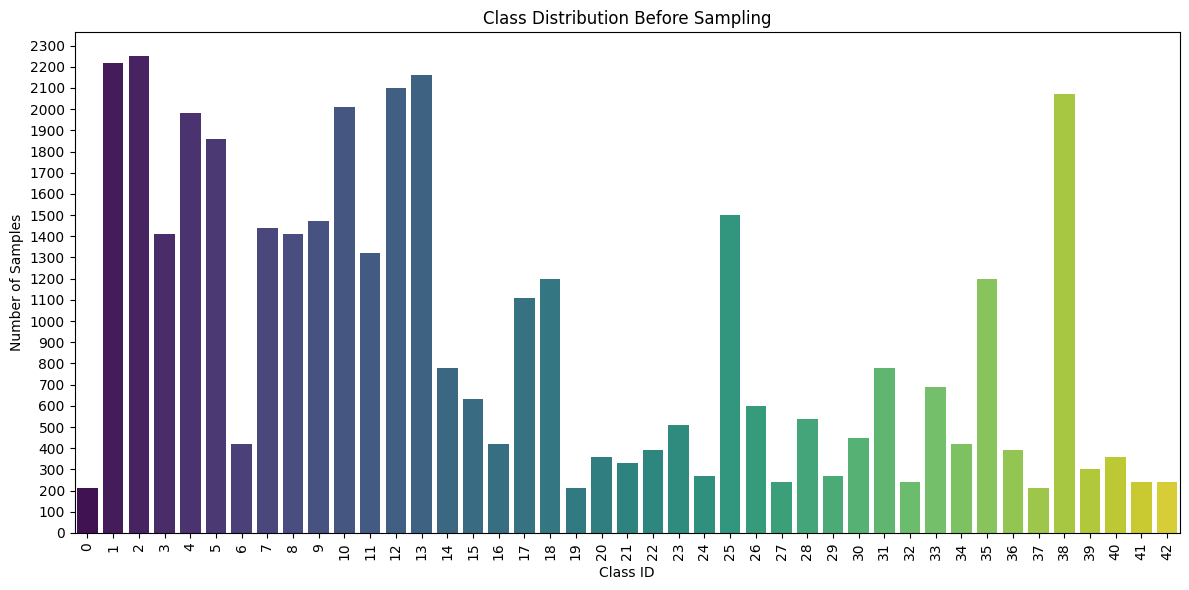

/tmp/ipython-input-39-714123136.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=200, random_state=42))
100%|██████████| 8600/8600 [01:07<00:00, 127.86it/s]


In [ ]:

# === SETUP ===
seed = 42

# Set a fixed random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Force cuDNN to use deterministic algorithms (e.g., for convolution)
# Same inputs will always give the same outputs
torch.backends.cudnn.deterministic = True

# Disable cuDNN benchmarking to avoid selection of random fast algorithms
# Prevents PyTorch from picking random fast algorithms (which may vary run to run)
torch.backends.cudnn.benchmark = False


# Create new folders
os.makedirs('New_Train', exist_ok=True)
os.makedirs('New_Test', exist_ok=True)

# Create 43 class folders (0 to 42) inside New_Train to store processed images per class
for i in range(43):
    os.makedirs(os.path.join('New_Train', str(i)), exist_ok=True)

# === Load and Sample Training Data ===
train_df = pd.read_csv('Train.csv')

# Plot for class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='ClassId', palette='viridis')
plt.title('Class Distribution Before Sampling')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
# Set y-axis ticks by hundreds
max_count = train_df['ClassId'].value_counts().max()
plt.yticks(range(0, max_count + 100, 100))
plt.tight_layout()
# Save the plot as an image
plt.savefig('class_distribution.png')
# Show the plot in Google Colab
plt.show()

# Shuffle the dataset to randomize the order of images
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Sample exactly 200 images per class for imbalance
train_sampled_df = (
    train_df.groupby('ClassId', group_keys=False)
    .apply(lambda x: x.sample(n=200, random_state=42))
    .reset_index(drop=True)
)


# === Resize and Pad Function ===
# To resize each image to a uniform size (320x320) without distorting aspect ratio,
# adjust the bounding box accordingly after resizing and padding.
def resize_and_pad(image, bbox, target_size=(320, 320)):
    original_h, original_w = image.shape[:2]
    target_w, target_h = target_size

    scale = min(target_w / original_w, target_h / original_h)
    new_w = int(original_w * scale)
    new_h = int(original_h * scale)

    resized = cv2.resize(image, (new_w, new_h),
                         interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC)

    delta_w = target_w - new_w
    delta_h = target_h - new_h
    top, bottom = delta_h // 2, delta_h - delta_h // 2
    left, right = delta_w // 2, delta_w - delta_w // 2

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    x1, y1, x2, y2 = bbox
    x1 = int(x1 * scale + left)
    y1 = int(y1 * scale + top)
    x2 = int(x2 * scale + left)
    y2 = int(y2 * scale + top)

    return padded, (x1, y1, x2, y2)

# === Process Training Data ===
def process_train_dataset(df, base_folder, new_csv_path):
    processed_rows = [] # List to store info about processed images and updated bounding boxes

    # Iterate over each row (image info) in the DataFrame with progress bar
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        # Construct full image path from base folder and relative path stored in 'Path' column
        image_path = os.path.join(base_folder, row['Path'])
        image = cv2.imread(image_path) # Read the image using OpenCV

        # Extract original bounding box coordinates from the DataFrame
        bbox = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])

        # Resize the image and pad it to the target size (320x320),
        # and get adjusted bounding box coordinates to match resized image
        resized_img, new_bbox = resize_and_pad(image, bbox)

        # Get class ID for this image
        class_id = row['ClassId']

        # Create a new filename for the processed image, formatting with zero padding:
        # class ID with 2 digits, index with 5 digits, e.g. "03_00042.png"
        new_filename = f"{class_id:02d}_{idx:05d}.png"

        # Relative path where the new image will be saved (used in CSV later)
        new_rel_path = f"New_Train/{class_id}/{new_filename}"

         # Full path to save the processed image
        new_full_path = os.path.join('New_Train', str(class_id), new_filename)

        # Save the resized and padded image
        cv2.imwrite(new_full_path, resized_img)


        # Append metadata for this image to the list:
        # fixed size 320x320, new bounding box coordinates, class ID, and new image path
        processed_rows.append({
            'Width': 320,
            'Height': 320,
            'Roi.X1': new_bbox[0],
            'Roi.Y1': new_bbox[1],
            'Roi.X2': new_bbox[2],
            'Roi.Y2': new_bbox[3],
            'ClassId': class_id,
            'Path': new_rel_path
        })

    # After processing all images, save the updated metadata to a new CSV file
    pd.DataFrame(processed_rows).to_csv(new_csv_path, index=False)

# Run train preprocessing
# output CSV is 'Train_preprocessed.csv'
process_train_dataset(train_sampled_df, '.', 'Train_preprocessed.csv')

# === Prepare YOLO Directory Structure ===
# Define directory paths for YOLO training and validation images and labels
image_train_dir = 'data/images/train' # Directory for training images
image_val_dir = 'data/images/val'     # Directory for validation images
label_train_dir = 'data/labels/train' # Directory for training labels
label_val_dir = 'data/labels/val'     # Directory for validation labels

# Create these directories
for folder in [image_train_dir, image_val_dir, label_train_dir, label_val_dir]:
    os.makedirs(folder, exist_ok=True)

# === Train/Val Split and YOLO Formatting ===

# Load the preprocessed CSV file containing resized image info and bounding boxes
df = pd.read_csv('Train_preprocessed.csv')

# Split dataset into training and validation sets (80% train, 20% val),
# stratifying by 'ClassId' to keep class distribution consistent across splits,
# and set random_state for reproducibility
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClassId'], random_state=42)

# Function to convert bounding box info to YOLO format (normalized values)
def convert_to_yolo_format(row):
    # Extract bounding box corners from the DataFrame row
    x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
    # Get image width and height
    w, h = row['Width'], row['Height']

    # Calculate bounding box center coordinates, normalized to [0,1]
    x_center = ((x1 + x2) / 2) / w
    y_center = ((y1 + y2) / 2) / h

    # Calculate bounding box width and height, normalized to [0,1]
    width = (x2 - x1) / w
    height = (y2 - y1) / h

    # Return a string in YOLO format
    return f"{row['ClassId']} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"


# Function to copy images and create corresponding YOLO label files for a given dataset split
def process_dataset(df, img_dir, label_dir):
  # Iterate over each row (image + bbox info) in the DataFrame
    for _, row in df.iterrows():
        # Extract image filename from the stored relative path
        image_name = os.path.basename(row['Path'])
        # Create corresponding label filename by replacing image extension '.png' with '.txt'
        label_name = image_name.replace('.png', '.txt')

        # Copy the image file to the target image directory (train or val)
        shutil.copy(row['Path'], os.path.join(img_dir, image_name))

        # Convert the bounding box to YOLO format string
        yolo_line = convert_to_yolo_format(row)

        # Write the YOLO-formatted label line to a text file with the same name as the image
        with open(os.path.join(label_dir, label_name), 'w') as f:
            f.write(yolo_line + '\n')

# Run processing

# Run the processing on the training dataset: copy images + create labels
process_dataset(train_df, image_train_dir, label_train_dir)

# Run the processing on the validation dataset: copy images + create labels
process_dataset(val_df, image_val_dir, label_val_dir)

In [ ]:
# Define the path to the ZIP file containing the GTSDB training dataset with full-scene images
zip_path = 'GTSDB_Train.zip'

# Open the ZIP file in read mode
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # extracts into current directory, preserving structure
    zip_ref.extractall('.') # this will create folders like GTSDB_Train/Train/images

# Check the folder structure
print(os.listdir('GTSDB_Train/Train'))
print(os.listdir('GTSDB_Train/Train/images'))
print(os.listdir('GTSDB_Train/Train/labels'))


['images', 'labels']
['00456.jpg', '00264.jpg', '00368.jpg', '00192.jpg', '00030.jpg', '00366.jpg', '00072.jpg', '00209.jpg', '00125.jpg', '00440.jpg', '00095.jpg', '00173.jpg', '00402.jpg', '00372.jpg', '00505.jpg', '00240.jpg', '00254.jpg', '00107.jpg', '00461.jpg', '00481.jpg', '00500.jpg', '00495.jpg', '00419.jpg', '00048.jpg', '00140.jpg', '00012.jpg', '00014.jpg', '00191.jpg', '00083.jpg', '00287.jpg', '00482.jpg', '00016.jpg', '00309.jpg', '00150.jpg', '00061.jpg', '00171.jpg', '00084.jpg', '00560.jpg', '00303.jpg', '00408.jpg', '00591.jpg', '00122.jpg', '00556.jpg', '00266.jpg', '00111.jpg', '00098.jpg', '00283.jpg', '00228.jpg', '00564.jpg', '00060.jpg', '00235.jpg', '00188.jpg', '00392.jpg', '00053.jpg', '00243.jpg', '00418.jpg', '00469.jpg', '00381.jpg', '00159.jpg', '00331.jpg', '00503.jpg', '00148.jpg', '00465.jpg', '00200.jpg', '00265.jpg', '00196.jpg', '00237.jpg', '00274.jpg', '00176.jpg', '00044.jpg', '00215.jpg', '00297.jpg', '00353.jpg', '00546.jpg', '00370.jpg', '00

In [ ]:
def get_folder_stats(image_dir):
    # Collect all image file paths with .png or .jpg extensions in the directory
    image_paths = sorted(glob(os.path.join(image_dir, '*.png')) + glob(os.path.join(image_dir, '*.jpg')))
    shapes = [] # To store image shapes (height, width, channels)

    # Loop over all image paths to read their dimensions
    for img_path in image_paths:
        img = cv2.imread(img_path) # Read image
        if img is not None:
            shapes.append(img.shape)  # Append shape in (H, W, C) format

    total = len(image_paths) # Total number of images in the folder
    # Compute the average image shape (mean of height, width, channels)
    avg_shape = np.mean(shapes, axis=0).astype(int) if shapes else None
    return total, avg_shape # Return number of images and average shape

# === Define paths for training/validation images and labels ===
image_train_dir = 'data/images/train'
image_val_dir = 'data/images/val'
label_train_dir = 'data/labels/train'
label_val_dir = 'data/labels/val'

In [ ]:
# === Add Full Scene JPG Images from GTSDB (YOLO format) ===

# Define source directories
full_scene_image_dir = 'GTSDB_Train/Train/images'
full_scene_label_dir = 'GTSDB_Train/Train/labels'

# Get all JPG image files
image_paths = sorted(glob(os.path.join(full_scene_image_dir, '*.jpg')))
label_paths = [os.path.join(full_scene_label_dir, os.path.basename(p).replace('.jpg', '.txt')) for p in image_paths]

# Keep only pairs with existing labels
image_label_pairs = [(img, lbl) for img, lbl in zip(image_paths, label_paths) if os.path.exists(lbl)]

# 80/20 train-val split
train_pairs, val_pairs = train_test_split(image_label_pairs, test_size=0.2, random_state=42)

# Process and copy full-scene images + labels into YOLO folders
def process_full_scene(pairs, img_dest, label_dest):
    for img_path, lbl_path in tqdm(pairs, desc=f"Processing full-scene to {img_dest}"):
        img = cv2.imread(img_path)

        # Resize and pad full image
        padded_img, _ = resize_and_pad(img, (0, 0, img.shape[1], img.shape[0]))

        # Create new name (e.g., filename_full.jpg)
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        new_name = f"{base_name}_full.jpg"

        # Save processed image
        cv2.imwrite(os.path.join(img_dest, new_name), padded_img)

        # Copy label file (unchanged, already YOLO formatted)
        new_label_path = os.path.join(label_dest, new_name.replace('.jpg', '.txt'))
        shutil.copy(lbl_path, new_label_path)

# Apply processing to both sets
process_full_scene(train_pairs, image_train_dir, label_train_dir)
process_full_scene(val_pairs, image_val_dir, label_val_dir)

Processing full-scene to data/images/val: 100%|██████████| 102/102 [00:01<00:00, 59.33it/s]


In [ ]:
# Print dataset after adding full-scene images
print("\nDataset after adding full-scene images:")
for name, path in [('Train Images', image_train_dir),
                   ('Val Images', image_val_dir),
                   ('Train Labels', label_train_dir),
                   ('Val Labels', label_val_dir)]:
    if 'images' in path:
        count = len(glob(os.path.join(path, '*.png')) + glob(os.path.join(path, '*.jpg')))
    else:
        count = len(glob(os.path.join(path, '*.txt')))
    print(f"{name}: {count}")


Dataset after adding full-scene images:
Train Images: 7284
Val Images: 1822
Train Labels: 7284
Val Labels: 1822


In [ ]:
# === TRAINING YOLO ===
model = YOLO('yolov8s.yaml')

# Start training the model
model.train(
    data='traffic_sign.yaml', # Path to dataset config file
    epochs=50,  # Number of training epochs
    imgsz=320,  # Input image size
    batch=16,   # Batch size

    # === Data Augmentation Settings ===
    degrees=10,          # Random rotation ±10 degrees
    translate=0.1,       # Random translation (10% shift)
    scale=0.2,           # Random scale (zoom in/out by ±20%)
    shear=3,             # Shear angle ±3 degrees
    perspective=0.002,   # Perspective warping
    fliplr=0.0,          # Disable horizontal flipping
    hsv_h=0.015,         # Hue augmentation
    hsv_s=0.7,           # Saturation augmentation
    hsv_v=0.4,           # Value (brightness) augmentation
    mosaic=0.5,          # Probability of applying mosaic augmentation (combines 4 images)
    mixup=0.1            # Probability of applying mixup (blends 2 images/labels together)
)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=traffic_sign.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.yaml, momentum=0.937, mosaic=0.5, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.002, plots=True, pose=12.0, pretrained=True, p

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]

Overriding model.yaml nc=80 with nc=43

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

YOLOv8s summary: 129 layers, 11,152,241 parameters, 11,152,225 gradients, 28.7 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 102MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 989.7±416.2 MB/s, size: 93.4 KB)


train: Scanning /content/data/labels/train... 7284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7284/7284 [00:04<00:00, 1619.41it/s]


train: New cache created: /content/data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 510.8±57.8 MB/s, size: 120.8 KB)


val: Scanning /content/data/labels/val... 1822 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1822/1822 [00:01<00:00, 1556.36it/s]

val: New cache created: /content/data/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000213, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.14G      2.548      4.984      3.809          8        320: 100%|██████████| 456/456 [01:14<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:11<00:00,  5.06it/s]


                   all       1822       1822     0.0117      0.849      0.031     0.0132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.39G       1.73       3.82       2.73          5        320: 100%|██████████| 456/456 [01:09<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.74it/s]


                   all       1822       1822     0.0264      0.924     0.0786     0.0418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.43G      1.396      3.272      2.226          7        320: 100%|██████████| 456/456 [01:10<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.67it/s]


                   all       1822       1822      0.176      0.459       0.17      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.46G       1.27      3.006      2.058          8        320: 100%|██████████| 456/456 [01:06<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.74it/s]


                   all       1822       1822      0.461      0.456      0.273      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       1.5G      1.175      2.801      1.948          8        320: 100%|██████████| 456/456 [01:07<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.73it/s]

                   all       1822       1822      0.345      0.483      0.347      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.54G      1.108      2.627      1.871          8        320: 100%|██████████| 456/456 [01:06<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.73it/s]


                   all       1822       1822       0.42       0.63      0.518       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.57G      1.063      2.479       1.81          8        320: 100%|██████████| 456/456 [01:06<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.82it/s]


                   all       1822       1822      0.634      0.649      0.702      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.61G      1.022       2.31      1.757         10        320: 100%|██████████| 456/456 [01:06<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.00it/s]

                   all       1822       1822      0.661       0.75      0.773      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.64G       0.99      2.196      1.723         11        320: 100%|██████████| 456/456 [01:07<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.32it/s]

                   all       1822       1822      0.772       0.81      0.847      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.71G     0.9683      2.073      1.695          5        320: 100%|██████████| 456/456 [01:07<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.45it/s]

                   all       1822       1822      0.866      0.838      0.894      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.84G     0.9502      1.984      1.673          9        320: 100%|██████████| 456/456 [01:07<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.40it/s]

                   all       1822       1822       0.92      0.881      0.923      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.88G     0.9233      1.856      1.637          8        320: 100%|██████████| 456/456 [01:06<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.80it/s]

                   all       1822       1822      0.949      0.886      0.929      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.91G     0.9037      1.773      1.622          5        320: 100%|██████████| 456/456 [01:06<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.85it/s]

                   all       1822       1822      0.966      0.904      0.939      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.96G     0.8859      1.708      1.599          9        320: 100%|██████████| 456/456 [01:06<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.81it/s]

                   all       1822       1822      0.973      0.904      0.937      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.03G     0.8724      1.669      1.589          8        320: 100%|██████████| 456/456 [01:06<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.86it/s]

                   all       1822       1822      0.974      0.922      0.944      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.09G     0.8556       1.61      1.566          4        320: 100%|██████████| 456/456 [01:07<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.77it/s]

                   all       1822       1822       0.98      0.918      0.945      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.16G     0.8373      1.553      1.542         12        320: 100%|██████████| 456/456 [01:07<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.82it/s]

                   all       1822       1822      0.981      0.918      0.946      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.22G     0.8271      1.505      1.528         11        320: 100%|██████████| 456/456 [01:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.14it/s]


                   all       1822       1822      0.973      0.919      0.947      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.29G     0.8158      1.466      1.517          7        320: 100%|██████████| 456/456 [01:07<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.39it/s]


                   all       1822       1822       0.99      0.929      0.946      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.36G     0.8073      1.444      1.507          7        320: 100%|██████████| 456/456 [01:08<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.54it/s]

                   all       1822       1822      0.986      0.928      0.947      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.42G     0.7982      1.396      1.498          9        320: 100%|██████████| 456/456 [01:07<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.55it/s]

                   all       1822       1822      0.986      0.927      0.948      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.48G     0.7816      1.363      1.476          8        320: 100%|██████████| 456/456 [01:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.86it/s]

                   all       1822       1822      0.989      0.934      0.949      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.56G      0.777      1.335      1.471          7        320: 100%|██████████| 456/456 [01:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.80it/s]

                   all       1822       1822      0.988      0.934      0.949      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.62G     0.7706      1.325      1.466          8        320: 100%|██████████| 456/456 [01:07<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.82it/s]

                   all       1822       1822      0.992      0.933       0.95       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.68G     0.7642      1.308      1.456          9        320: 100%|██████████| 456/456 [01:07<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.77it/s]

                   all       1822       1822      0.984      0.934      0.951      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.76G     0.7477      1.292      1.441         12        320: 100%|██████████| 456/456 [01:06<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.83it/s]

                   all       1822       1822      0.991      0.935       0.95      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.81G     0.7474      1.273      1.433          9        320: 100%|██████████| 456/456 [01:07<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.80it/s]

                   all       1822       1822      0.991      0.933       0.95      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.88G     0.7444      1.257      1.438          7        320: 100%|██████████| 456/456 [01:07<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.83it/s]


                   all       1822       1822      0.991      0.935      0.949       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.95G     0.7328      1.223      1.427          7        320: 100%|██████████| 456/456 [01:07<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.95it/s]


                   all       1822       1822      0.991      0.938      0.951      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.01G     0.7167      1.205      1.409          6        320: 100%|██████████| 456/456 [01:07<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.02it/s]


                   all       1822       1822      0.991      0.937      0.952      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.08G     0.7202      1.195      1.413          4        320: 100%|██████████| 456/456 [01:07<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.32it/s]

                   all       1822       1822      0.992      0.938      0.952      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.15G     0.7107      1.177      1.404          7        320: 100%|██████████| 456/456 [01:08<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.51it/s]


                   all       1822       1822      0.993      0.934      0.952      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       3.2G     0.7164      1.182      1.406          9        320: 100%|██████████| 456/456 [01:09<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.51it/s]


                   all       1822       1822       0.99      0.937      0.952      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.28G     0.7015      1.162       1.39          5        320: 100%|██████████| 456/456 [01:08<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.59it/s]

                   all       1822       1822      0.993      0.939      0.954      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.34G     0.6976      1.134      1.382         11        320: 100%|██████████| 456/456 [01:08<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.55it/s]

                   all       1822       1822      0.993      0.936      0.953      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       3.4G     0.6935      1.136      1.382          7        320: 100%|██████████| 456/456 [01:09<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.52it/s]

                   all       1822       1822      0.989      0.941      0.954      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.47G     0.6874       1.12      1.373          9        320: 100%|██████████| 456/456 [01:08<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.22it/s]

                   all       1822       1822      0.992       0.94      0.954      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.54G     0.6871      1.116      1.375          8        320: 100%|██████████| 456/456 [01:08<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.20it/s]

                   all       1822       1822      0.991       0.94      0.953       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       3.6G     0.6811      1.098      1.369          7        320: 100%|██████████| 456/456 [01:07<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.86it/s]

                   all       1822       1822      0.994      0.936      0.953      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.67G     0.6753      1.089      1.361          8        320: 100%|██████████| 456/456 [01:07<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.81it/s]

                   all       1822       1822      0.993      0.936      0.954      0.858


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.72G     0.4657     0.2994      1.262          4        320: 100%|██████████| 456/456 [01:04<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.80it/s]

                   all       1822       1822      0.994      0.938      0.956      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.79G     0.4572     0.2866       1.25          4        320: 100%|██████████| 456/456 [01:03<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.41it/s]


                   all       1822       1822      0.994      0.938      0.957      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.86G     0.4546      0.283      1.245          4        320: 100%|██████████| 456/456 [01:03<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.90it/s]

                   all       1822       1822      0.993      0.939      0.958      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.92G     0.4411     0.2754      1.226          4        320: 100%|██████████| 456/456 [01:04<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.84it/s]

                   all       1822       1822      0.995      0.937      0.957      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.99G     0.4357     0.2706      1.225          4        320: 100%|██████████| 456/456 [01:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  6.29it/s]

                   all       1822       1822      0.994      0.938      0.957       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.06G      0.431     0.2673      1.218          4        320: 100%|██████████| 456/456 [01:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.84it/s]

                   all       1822       1822      0.995      0.939      0.958      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.12G     0.4286     0.2652      1.214          4        320: 100%|██████████| 456/456 [01:03<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.37it/s]


                   all       1822       1822      0.995       0.94      0.957      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.19G     0.4236      0.261      1.207          4        320: 100%|██████████| 456/456 [01:03<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.75it/s]

                   all       1822       1822      0.993       0.94      0.958      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.26G     0.4151     0.2559      1.199          4        320: 100%|██████████| 456/456 [01:04<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.81it/s]

                   all       1822       1822      0.993       0.94      0.958      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.32G     0.4132     0.2535      1.197          4        320: 100%|██████████| 456/456 [01:04<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.56it/s]


                   all       1822       1822      0.994       0.94      0.958      0.876

50 epochs completed in 1.070 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s summary (fused): 72 layers, 11,142,225 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:11<00:00,  5.16it/s]


                   all       1822       1822      0.994       0.94      0.958      0.876
  Speed limit (20km/h)         41         41      0.995      0.951      0.978      0.887
  Speed limit (30km/h)         43         43      0.975      0.898      0.945      0.866
  Speed limit (50km/h)         46         46      0.988       0.87      0.893        0.8
  Speed limit (60km/h)         42         42      0.974      0.952      0.961      0.878
  Speed limit (70km/h)         46         46      0.994      0.848      0.899      0.842
  Speed limit (80km/h)         43         43          1      0.824      0.946      0.865
End of speed limit (80km/h)         42         42      0.995      0.952      0.964      0.885
 Speed limit (100km/h)         45         45      0.975      0.854      0.894      0.807
 Speed limit (120km/h)         42         42      0.998      0.929      0.962      0.872
         No overtaking         46         46          1      0.868      0.899      0.832
No overtaking by

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79023b109290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.03

In [ ]:
# === INFERENCE ON TEST SET ===

# Load test dataset CSV which contains image paths and bounding box annotations
test_df = pd.read_csv('Test.csv')


# Function to resize and pad test images while adjusting bounding boxes accordingly
def process_test_dataset(df, base_folder, new_csv_path):
    processed_rows = []    # List to hold processed image metadata for new CSV

    # Loop through each row in the test DataFrame with a progress bar
    for idx, row in tqdm(df.iterrows(), total=len(df)):

        # Construct full image path using base folder and relative path from CSV
        image_path = os.path.join(base_folder, row['Path'])
        image = cv2.imread(image_path)  # Read the image

        # Extract original bounding box coordinates (x1, y1, x2, y2)
        bbox = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
        resized_img, new_bbox = resize_and_pad(image, bbox)  # Resize and pad the image

        # Retrieve the class ID
        class_id = row['ClassId']
        # Create a new filename for the resized image, padded for consistent sorting
        new_filename = f"{class_id:02d}_{idx:05d}.png"
        # Relative path where the new image will be saved
        new_rel_path = f"New_Test/{new_filename}"
        # Full path
        new_full_path = os.path.join('New_Test', new_filename)

        # Save the resized and padded image
        cv2.imwrite(new_full_path, resized_img)

        # Store updated image metadata and bounding box info for the new CSV
        processed_rows.append({
            'Width': 320,
            'Height': 320,
            'Roi.X1': new_bbox[0],
            'Roi.Y1': new_bbox[1],
            'Roi.X2': new_bbox[2],
            'Roi.Y2': new_bbox[3],
            'ClassId': class_id,
            'Path': new_rel_path
        })

    # After processing all images, save the updated metadata to a new CSV file
    pd.DataFrame(processed_rows).to_csv(new_csv_path, index=False)

# Run the preprocessing function on the test dataset to prepare resized images and new CSV
process_test_dataset(test_df, '.', 'Test_preprocessed.csv')

100%|██████████| 12630/12630 [01:26<00:00, 146.29it/s]


In [ ]:
# === Run YOLOv8 Inference ===

# Load the trained YOLOv8 model using the best weights from training
model = YOLO('runs/detect/train/weights/best.pt')

# Run inference on the test images located in 'New_Test'
# Set high confidence threshold (0.9) to filter only high-confidence predictions
results = model.predict(source='New_Test', conf=0.9, save=False)

# === Annotate and Save Results ===

# Create output directory to save annotated images (with predicted bounding boxes and class labels)
output_dir = 'test_results_labeled'
os.makedirs(output_dir, exist_ok=True) # Create directory

# Loop through all results returned by the YOLO model
for result in results:
    img = result.orig_img.copy()  # Make a copy of the original image

    # Loop through each detected bounding box, class ID, and confidence score
    for box, cls_id, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        cls_id = int(cls_id)  # Convert class ID from tensor to integer
        conf = float(conf)    # Convert confidence score to float
        x1, y1, x2, y2 = map(int, box)   # Convert box coordinates to integers

        # Prepare label text with class ID and confidence percentage
        label = f"Class {cls_id} ({conf*100:.2f}%)"

        # Draw bounding box (green rectangle) around the detected object
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Put the label above the bounding box (blue text)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Extract original image filename from result
    filename = os.path.basename(result.path)

    # Save the annotated image to the output directory
    cv2.imwrite(os.path.join(output_dir, filename), img)

print(f"Labeled test images saved to: {output_dir}")
print("Results with confidence saved to:", output_dir)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
image 7634/12630 /content/New_Test/15_04306.png: 320x320 (no detections), 7.7ms
image 7635/12630 /content/New_Test/15_04345.png: 320x320 1 No vehicles of any kind permitted, 7.7ms
image 7636/12630 /content/New_Test/15_04366.png: 320x320 1 No vehicles of any kind permitted, 8.0ms
image 7637/12630 /content/New_Test/15_04375.png: 320x320 1 No vehicles of any kind permitted, 7.8ms
image 7638/12630 /content/New_Test/15_04401.png: 320x320 1 No vehicles of any kind permitted, 8.4ms
image 7639/12630 /content/New_Test/15_04581.png: 320x320 (no detections), 9.2ms
image 7640/12630 /content/New_Test/15_04777.png: 320x320 1 No vehicles of any kind permitted, 8.7ms
image 7641/12630 /content/New_Test/15_04790.png: 320x320 (no detections), 10.2ms
image 7642/12630 /content/New_Test/15_04863.png: 320x320 1 No vehicles of any kind permitted, 8.2ms
image 7643/12630 /content/New_Test/15_04876.png: 320x320 1 No vehicles of any kind permitted, 7.0ms
imag

In [ ]:
# Mapping class ID to label name
class_names = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No overtaking",
    10: "No overtaking by vehicles over 3.5 t",
    11: "Intersection ahead - right-of-way only for this intersection",
    12: "Priority road - right-of-way on all following intersections",
    13: "Yield",
    14: "Stop",
    15: "No vehicles of any kind permitted",
    16: "No vehicles over 3.5 t permitted",
    17: "No entry",
    18: "Other dangers",
    19: "Curve (left)",
    20: "Curve (right)",
    21: "Double curve (first left)",
    22: "Uneven road",
    23: "Slippery road",
    24: "Road narrows (right)",
    25: "Roadworks",
    26: "Traffic signals ahead",
    27: "Pedestrian crossing",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Ice or snow",
    31: "Wild animals crossing",
    32: "End of all restrictions",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Go straight ahead",
    36: "Go straight or turn right ahead",
    37: "Go straight or turn left ahead",
    38: "Pass on the right",
    39: "Pass on the left",
    40: "Roundabout",
    41: "End of no overtaking",
    42: "End of no overtaking by vehicles over 3.5 t"
}

In [ ]:
# === Extract a Frame from a Video at a Specific Timestamp ===

# Path to the input video file
video_path = 'video2.mp4'
# Open the video file
cap = cv2.VideoCapture(video_path)
# Get the frames per second (fps) of the video to calculate time-based frame inde
fps = cap.get(cv2.CAP_PROP_FPS)
# Compute the frame number that corresponds to 2.5 seconds into the video
frame_number = int(2.5 * fps)
# Move the video reader to the calculated frame number
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
# Read the selected frame
ret, frame = cap.read()
# Release the video capture
cap.release()


# Save the annotated image
cv2.imwrite('/content/output_frame.jpg', frame)


True

In [ ]:
# === Load the image ===

# Path to the image extracted from a video frame
large_image_path = '/content/output_frame.jpg'

# Load the image
large_image = cv2.imread(large_image_path)

# Get the image's height and width
H, W = large_image.shape[:2]

# Print the loaded image dimensions
print(f"Loaded image size: {W}x{H}")

# === Load the YOLOv8 model ===

# Load the trained YOLO model from the specified path
model = YOLO('runs/detect/train/weights/best.pt')

# === Sliding window parameters ===

win_w, win_h = 160, 160         # Use a fixed sliding window size (width x height)
curr_stride = 32                # Number of pixels to move the window at each step (horizontal/vertical)
input_size = 320                # The YOLO model expects 320x320 input images
CONF_THRESH = 0.9               # Detections below this confidence threshold are ignored
detections = []                 # List to store all detected bounding boxes (before NMS)

# === Slide window across the image ===

# Slide the window from top to bottom (y-direction)
for y in range(0, H - win_h + 1, curr_stride):
    # Slide the window from left to right (x-direction)
    for x in range(0, W - win_w + 1, curr_stride):
        # Crop the current window (region of interest) from the image
        crop = large_image[y:y + win_h, x:x + win_w]

        # Resize the crop to match YOLO’s expected input size
        resized_crop = cv2.resize(crop, (input_size, input_size), interpolation=cv2.INTER_AREA)

        # Run YOLO detection on the resized crop
        result = model(resized_crop, verbose=False)[0]

        # If any bounding boxes are detected
        if result.boxes is not None and len(result.boxes) > 0:
            # Loop through each detected bounding box
            for box in result.boxes:
                conf = float(box.conf[0])  # Confidence score
                if conf < CONF_THRESH:
                    continue  # Skip low-confidence detections

                cls = int(box.cls[0])  # Class ID
                bx1, by1, bx2, by2 = box.xyxy[0].cpu().numpy()  # Bounding box coordinates in resized crop

                # Scale bounding box coordinates back to original crop window size
                scale_x = win_w / input_size
                scale_y = win_h / input_size
                rx1 = int(x + bx1 * scale_x)  # Rescaled top-left X
                ry1 = int(y + by1 * scale_y)  # Rescaled top-left Y
                rx2 = int(x + bx2 * scale_x)  # Rescaled bottom-right X
                ry2 = int(y + by2 * scale_y)  # Rescaled bottom-right Y

                # Append detection (coordinates, confidence, class ID)
                detections.append((rx1, ry1, rx2, ry2, conf, cls))

# === Intersection over Union (IoU) function used in NMS ===

def iou(box1, box2):
    # Unpack coordinates of both boxes
    xa, ya, xb, yb = box1
    xc, yc, xd, yd = box2

    # Compute the coordinates of the intersection box
    inter_x1 = max(xa, xc)
    inter_y1 = max(ya, yc)
    inter_x2 = min(xb, xd)
    inter_y2 = min(yb, yd)

    # Compute intersection area
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Compute areas of each box
    box1_area = (xb - xa) * (yb - ya)
    box2_area = (xd - xc) * (yd - yc)

    # Compute union area
    union = box1_area + box2_area - inter_area

    # Return IoU (intersection over union)
    return inter_area / union if union > 0 else 0

# === Non-Maximum Suppression (NMS) to reduce overlapping detections ===

def nms(boxes, iou_thresh=0.3):
    # Sort detections by confidence score (highest first)
    boxes = sorted(boxes, key=lambda x: x[4], reverse=True)
    final = []  # Final detections after removing overlaps

    while boxes:
        best = boxes.pop(0)  # Take the highest-confidence box
        final.append(best)
        # Remove all other boxes that overlap too much with the best one
        boxes = [b for b in boxes if iou(best[:4], b[:4]) < iou_thresh]

    return final

# === Apply NMS to remove duplicate/overlapping boxes ===

nms_detections = nms(detections)

# === Draw the final detections on the image ===

for (x1, y1, x2, y2, conf, cls) in nms_detections:
    # Draw a green rectangle for each final detection
    cv2.rectangle(large_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Convert class ID to class name using class_names dictionary
    label_name = class_names.get(cls, f"Class {cls}")

    # Put class label and confidence score above the box
    cv2.putText(large_image, f"{label_name} ({conf:.2f})", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# === Save the output image with all final bounding boxes drawn ===

cv2.imwrite('final_detected_large_image.jpg', large_image)
print("Final detection saved as 'final_detected_large_image.jpg'")


Loaded image size: 1280x720
Final detection saved as 'final_detected_large_image.jpg'
